# Model v12

This model was trained and tested with images validated to contain a path (second round of validation).

Roughness metric = 1 second ahead, k-means 2.

## Set-up

In [ ]:
!pip install wandb

In [ ]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 20kB/s 
     |████████████████████████████████| 4.0MB 46.0MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
!ls '/gdrive/My Drive/Labeling/Model/'

ImageFolder.ipynb  Images  Models.gdoc	Previous  v10  v11  v12  v8  v9


In [ ]:
from fastai.vision import *
import pandas as pd
import numpy as np
import os

In [ ]:
import wandb
from wandb.fastai import WandbCallback

wandb.init(project='roughness-classifier-2')

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Model with `get_transforms(do_flip=False)`

#### Load data

In [ ]:
path = '/gdrive/My Drive/Labeling/Model'
folder_path = os.path.join(path, 'v12')
image_path = os.path.join(path, 'Images')
label_path = '/gdrive/My Drive/Labeling/LabelsCSV/random_split/Metric2'

In [ ]:
df = pd.read_csv(os.path.join(label_path, 'all_labels_path_metric_2_train.csv'))
df = df.filter(items=['image', 'group_2'])
df['group_2'] = df['group_2'].astype(int).astype(str)
df.head()

,image,group_2
0,969902383s228ms.jpg,0
1,969902516s227ms.jpg,0
2,969902832s243ms.jpg,0
3,970330409s202ms.jpg,0
4,969901887s232ms.jpg,0


In [ ]:
print('All images:', len(os.listdir(image_path)))
print('Images in Path folder', len(os.listdir('/gdrive/My Drive/Labeling/PathDetectionClassifier/PredictImages/Path')))
print('Images in CSV (80% of Path folder):', len(df))

All images: 8983
Images in Path folder 7070
Images in CSV (80% of Path folder): 5647


#### Balance classes

In [ ]:
group_0 = df[df['group_2'] == '0']
group_1 = df[df['group_2'] == '1']

print(len(group_0))
print(len(group_1))

4359
1288


In [ ]:
group_0 = group_0[:1500]

df_balanced = group_0.append(group_1)

print(len(df_balanced))
print(len(df_balanced[df_balanced['group_2'] == '0']))
print(len(df_balanced[df_balanced['group_2'] == '1']))

2788
1500
1288


#### DataBunch

The original image size is 3840 x 2160. We resize (squish) to a smaller image with the same aspect ratio (270 x 480, decreased by a factor of 8) [Link](https://fastai1.fast.ai/vision.transform.html#Data-augmentation-details).

In [ ]:
bs = 64
# bs = 16    # uncomment this line if you run out of memory

In [ ]:
np.random.seed(42)
data = (ImageList
        .from_df(path=image_path, df=df_balanced)
        .split_by_rand_pct(0.2)
        .label_from_df()
        .transform(get_transforms(do_flip=False), size=(270,480))
        .databunch(bs=bs)
        .normalize())

In [ ]:
train_x = data.train_ds.x
train_y = data.train_ds.y
valid_x = data.valid_ds.x
valid_y = data.valid_ds.y

print(len(train_x), len(train_y))
print(len(valid_x), len(valid_y))

2311 2311
577 577


In [ ]:
print(data.classes)

['0', '1']


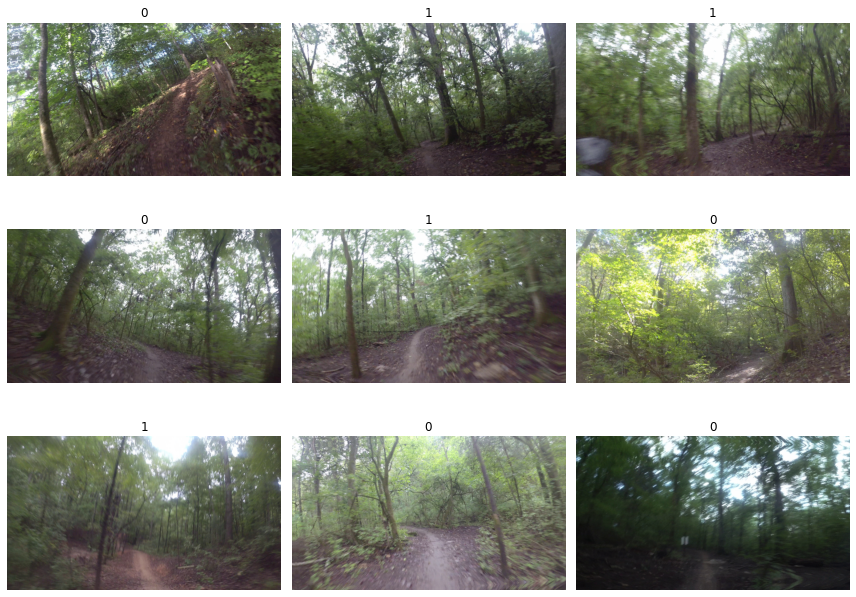

In [ ]:
data.show_batch(rows=3, figsize=(12,9))

#### ResNet50

In [ ]:
arch = models.resnet50
learn = cnn_learner(data, arch, metrics=[accuracy], callback_fns=WandbCallback)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


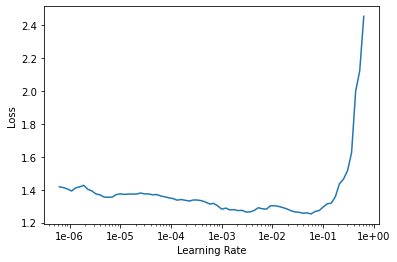

In [ ]:
learn.recorder.plot()

In [ ]:
lr = 0.005

In [ ]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,1.337209,1.014015,0.624776,11:11
1,0.977220,0.678201,0.660682,09:25
2,0.789764,0.602688,0.689408,09:24
3,0.674366,0.604064,0.696589,09:30
4,0.624014,0.588740,0.709156,09:27


Better model found at epoch 0 with valid_loss value: 1.0140151977539062.
Better model found at epoch 1 with valid_loss value: 0.6782010793685913.
Better model found at epoch 2 with valid_loss value: 0.6026880741119385.
Better model found at epoch 4 with valid_loss value: 0.5887402892112732.
Loaded best saved model from /content/wandb/run-20201224_182757-3ddbz4i1/files/bestmodel.pth


In [ ]:
learn.save(os.path.join(folder_path, 'v12-stage-1'))

In [ ]:
learn.fit_one_cycle(2, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.598872,0.604178,0.684022,09:30
1,0.582822,0.584679,0.689408,09:28


Better model found at epoch 0 with valid_loss value: 0.6041781902313232.
Better model found at epoch 1 with valid_loss value: 0.5846794843673706.
Loaded best saved model from /content/wandb/run-20201224_182757-3ddbz4i1/files/bestmodel.pth


In [ ]:
learn.load(os.path.join(folder_path, 'v12-stage-1'))

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

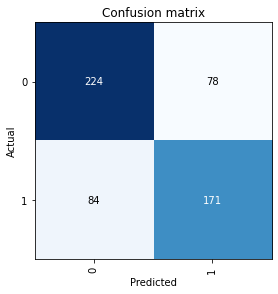

In [ ]:
interp.plot_confusion_matrix()

#### Fine-tune

In [ ]:
bs = 16    # uncomment this line if you run out of memory
learn.data.batch_size = 16

In [ ]:
learn.data.batch_size

16

In [ ]:
learn.load(os.path.join(folder_path, 'v12-stage-1'))

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


Loaded best saved model from /content/wandb/run-20201224_182757-3ddbz4i1/files/bestmodel.pth
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


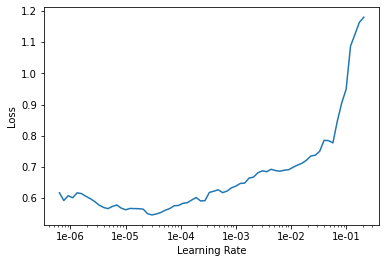

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.587268,0.575972,0.703770,09:43
1,0.589464,0.571392,0.707361,09:37
2,0.542115,0.580160,0.719928,09:37
3,0.535722,0.567438,0.739677,09:33
4,0.500320,0.563013,0.734291,09:30


Better model found at epoch 0 with valid_loss value: 0.5759721398353577.
Better model found at epoch 1 with valid_loss value: 0.5713919401168823.
Better model found at epoch 3 with valid_loss value: 0.5674375295639038.
Better model found at epoch 4 with valid_loss value: 0.563012957572937.
Loaded best saved model from /content/wandb/run-20201224_182757-3ddbz4i1/files/bestmodel.pth


In [ ]:
learn.save(os.path.join(folder_path, 'v12-stage-2'))

In [ ]:
learn.fit_one_cycle(2, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.490797,0.569634,0.734291,09:34
1,0.476510,0.574067,0.714542,09:41


Better model found at epoch 0 with valid_loss value: 0.5696340203285217.
Loaded best saved model from /content/wandb/run-20201224_182757-3ddbz4i1/files/bestmodel.pth


In [ ]:
learn.load(os.path.join(folder_path, 'v12-stage-2'))

In [ ]:
learn.freeze()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

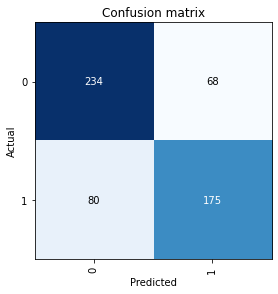

In [ ]:
interp.plot_confusion_matrix()

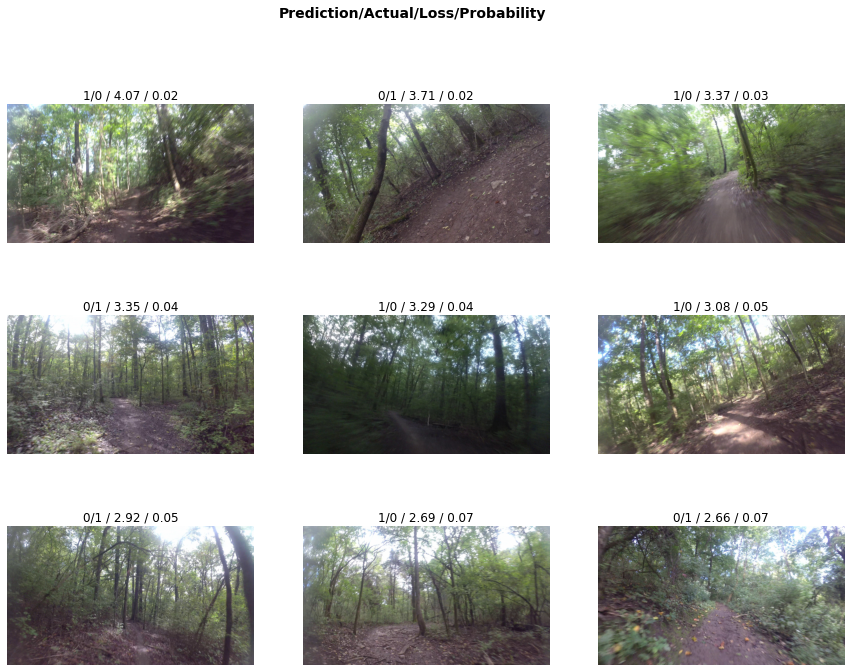

In [ ]:
 interp.plot_top_losses(9, figsize=(15,11))